In [140]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import waterfall_chart
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = [18, 10]

## Loading data


In [2]:
data = pd.read_stata('HCMST 2017 fresh sample for public sharing draft v1.1.dta')
data.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


### Chosen columns:
     pphhsize - Household Size
     relate_duration_at_w6_years - july 2017-year and month when rel started
     w6_friend_connect_4 - partner knows my friends and I know my partner's friends before metting
     w6_otherdate - In the past year, have you ever met someone for dating, for romance, or for sex
     S1 - Are you married? (output)

### Dropping rows, which had nulls and changing categorical data

In [4]:
data = data[['pphhsize', 'relate_duration_at_w6_years', 'w6_friend_connect_4', 'w6_otherdate', 'S1']].dropna()
data['pphhsize'] = data['pphhsize'].astype(float)
data = pd.get_dummies(data)

#### Rows with an answer *Refused* in *w6_otherdate* also admitted as null

In [5]:
data = data.loc[data['w6_otherdate_Refused'] == 0] 
data.drop('w6_otherdate_Refused', axis=1, inplace=True)

#### Renaming columns and splitting for train and test

In [7]:
data.rename(columns={'relate_duration_at_w6_years': 'relate_duration',
            'w6_friend_connect_4_Yes': 'friends_connect',
            'w6_otherdate_No, I have not met anyone for dating, romance, or sex besides [Partner Name] in the past year.': 'otherdate',
            'S1_Yes, I am Married':'married'},
            inplace=True)
data = data.reset_index()
data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate', 'married']]

X_data, y_data = data[['pphhsize', 'relate_duration', 'friends_connect', 'otherdate']], data[['married']]
y_data = np.array(y_data).ravel()
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

### Training model

In [9]:
cls = RandomForestClassifier(n_estimators=500)
cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)

### Mean model response

In [132]:
def mean_model_resp(data, model, sample):
    data = data.copy()
    plot_data = pd.DataFrame({'col': ['intercept'] + list(sample.keys())})
    plot_data.set_index('col', inplace=True)
    plot_data['proba'] = 0
    plot_data.loc['intercept', 'proba'] = model.predict_proba(data)[:,1].mean()
    for key, value in sample.items():
        data.loc[:, key] = value
        plot_data.loc[key, 'proba'] = model.predict_proba(data)[:,1].mean()
    plot_data['proba'] = plot_data['proba'].diff().fillna(plot_data['proba'])
    waterfall_chart.plot(plot_data.index, plot_data['proba'], rotation_value=0, formatting='{:,.3f}')  

#### First sample

In [146]:
sample = OrderedDict(X_test.sample(1, random_state=592).to_dict('records')[0])
sample

OrderedDict([('pphhsize', 2.0),
             ('relate_duration', 21.33333396911621),
             ('friends_connect', 0),
             ('otherdate', 1)])

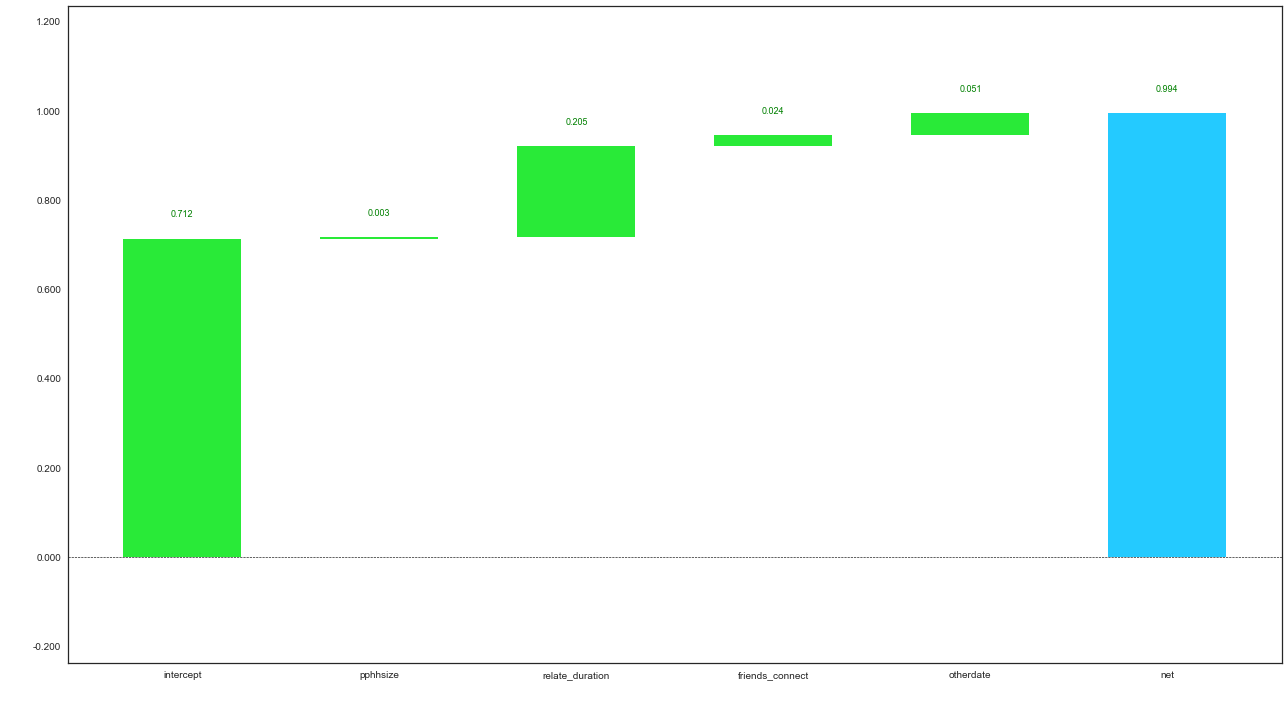

In [136]:
mean_model_resp(X_test, cls,  sample)

#### Changing order in sample

In [148]:
sample.move_to_end('pphhsize')
sample.move_to_end('relate_duration')
sample

OrderedDict([('friends_connect', 0),
             ('otherdate', 1),
             ('pphhsize', 2.0),
             ('relate_duration', 21.33333396911621)])

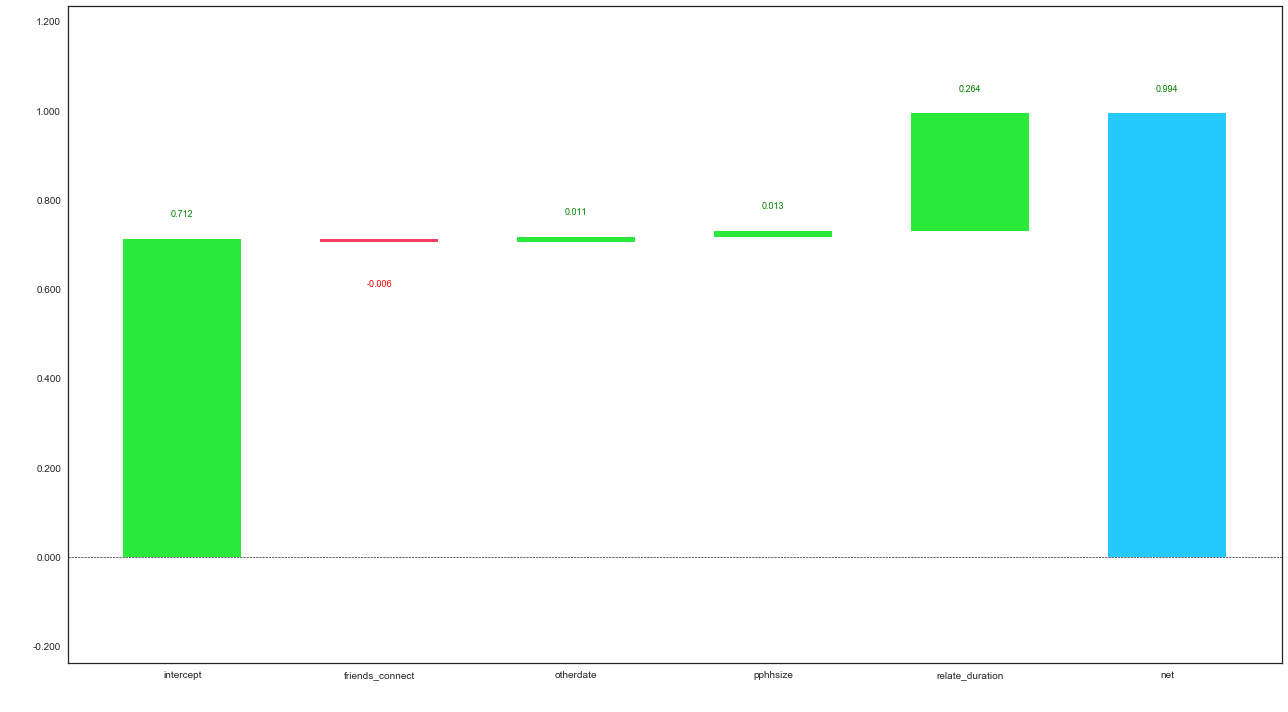

In [149]:
mean_model_resp(X_test, cls,  sample)

###### W obu przypadkach kolejności najistotniejszy wpływ na decyzję modelu miała zmienna relate_duration, mówiąca o długości trwania związku (dla wysokiej wartości 21 lat znacznie zwiększała przewidywanie o małżeństwie). Zmiana kolejności najbardziej zmieniła średni wpływ zmiennej otherdate, która przed informacją o długości związku w zasadzie nie zmienia przewidywań, co sugeruje, że w dłuższych związkach randkowanie zaczyan być powiązane z małżeństwem.

#### Second sample

In [155]:
sample = OrderedDict(X_test.sample(1, random_state=178).to_dict('records')[0])
sample

OrderedDict([('pphhsize', 1.0),
             ('relate_duration', 0.6666666865348816),
             ('friends_connect', 0),
             ('otherdate', 1)])

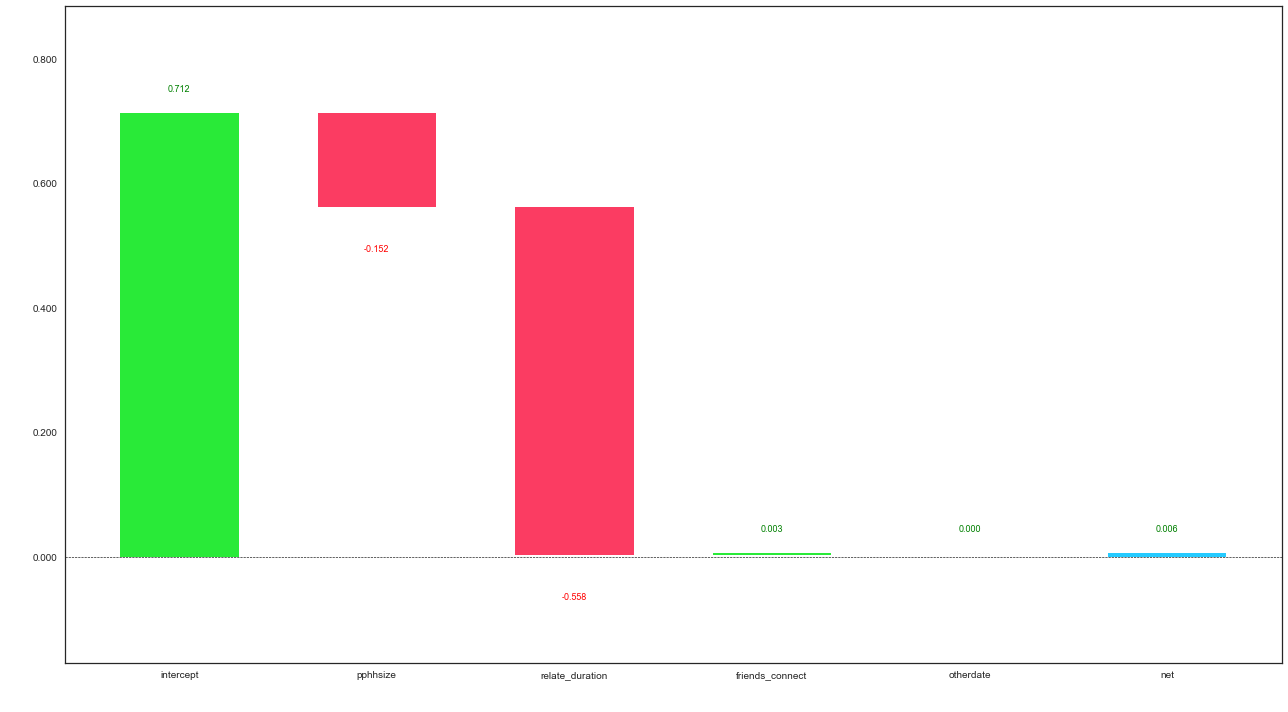

In [156]:
mean_model_resp(X_test, cls,  sample)

#### Changing order in sample

In [157]:
sample.move_to_end('relate_duration')
sample.move_to_end('pphhsize')
sample

OrderedDict([('friends_connect', 0),
             ('otherdate', 1),
             ('relate_duration', 0.6666666865348816),
             ('pphhsize', 1.0)])

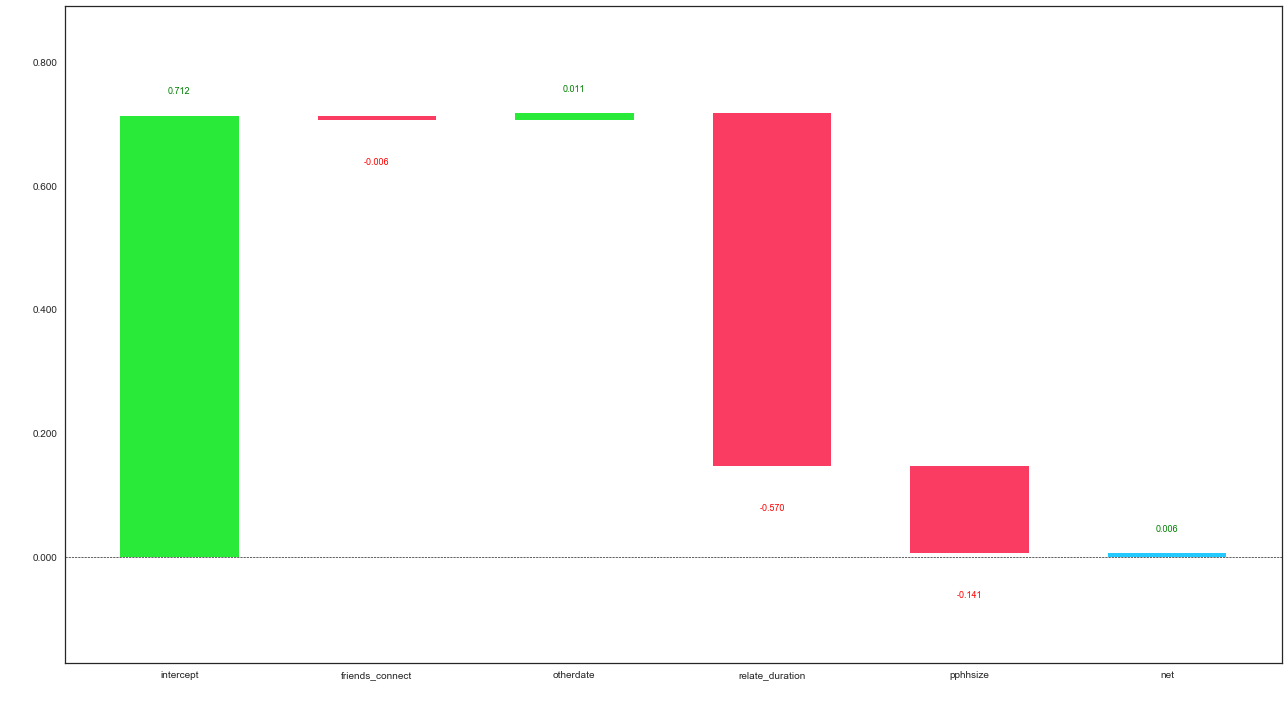

In [158]:
mean_model_resp(X_test, cls,  sample)

#### W drugim przypadku również najistotniejsze zmiany powoduje zmienna dotycząca długości związku. W tym przypadku, zmienna mówiąca o tym, że w danym domu mieszka jedna osoba również powoduje spadek przewidywalnia małżeństwa (co zasadniczo jest spodziewane). Kolejność zmiennych nie powoduje jednak znacznych zmian wartości, co sugeruje, że zmienne nie wpływają na siebie.